# Logistic Regression

In this notebook, we implement three logistic regression classifiers with different features. All models are using $L_1$ penalty, and the regularization power is tuned using the Nested Cross-Validation scheme.

## Table of Contents

<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Nested-Cross-Validation-Scheme" data-toc-modified-id="1.-Nested-Cross-Validation-Scheme-1">1. Nested Cross-Validation Scheme</a></span></li><li><span><a href="#2.-Logistic-Regression-with-Image-Pixel" data-toc-modified-id="2.-Logistic-Regression-with-Image-Pixel-2">2. Logistic Regression with Image Pixel</a></span><ul class="toc-item"><li><span><a href="#2.1.-Data-Preparation" data-toc-modified-id="2.1.-Data-Preparation-2.1">2.1. Data Preparation</a></span></li><li><span><a href="#2.2.-Model-Tuning/Training" data-toc-modified-id="2.2.-Model-Tuning/Training-2.2">2.2. Model Tuning/Training</a></span></li><li><span><a href="#2.3.-Model-Testing" data-toc-modified-id="2.3.-Model-Testing-2.3">2.3. Model Testing</a></span></li><li><span><a href="#2.4.-Model-Interpretation" data-toc-modified-id="2.4.-Model-Interpretation-2.4">2.4. Model Interpretation</a></span></li></ul></li><li><span><a href="#3.-Logistic-Regression-with-Cell-Size-and-Total-Intensity" data-toc-modified-id="3.-Logistic-Regression-with-Cell-Size-and-Total-Intensity-3">3. Logistic Regression with Cell Size and Total Intensity</a></span><ul class="toc-item"><li><span><a href="#3.1.-Data-Preparation" data-toc-modified-id="3.1.-Data-Preparation-3.1">3.1. Data Preparation</a></span></li><li><span><a href="#3.2.-Model-Tuning/Training" data-toc-modified-id="3.2.-Model-Tuning/Training-3.2">3.2. Model Tuning/Training</a></span></li><li><span><a href="#3.3.-Model-Testing" data-toc-modified-id="3.3.-Model-Testing-3.3">3.3. Model Testing</a></span></li><li><span><a href="#3.4.-Model-Interpretation" data-toc-modified-id="3.4.-Model-Interpretation-3.4">3.4. Model Interpretation</a></span></li></ul></li><li><span><a href="#4.-Logistic-Regression-with-CellProfiler-Features" data-toc-modified-id="4.-Logistic-Regression-with-CellProfiler-Features-4">4. Logistic Regression with CellProfiler Features</a></span><ul class="toc-item"><li><span><a href="#4.1.-Data-Preparation" data-toc-modified-id="4.1.-Data-Preparation-4.1">4.1. Data Preparation</a></span></li><li><span><a href="#4.2.-Model-Tuning/Training" data-toc-modified-id="4.2.-Model-Tuning/Training-4.2">4.2. Model Tuning/Training</a></span></li><li><span><a href="#4.3.-Model-Testing" data-toc-modified-id="4.3.-Model-Testing-4.3">4.3. Model Testing</a></span></li><li><span><a href="#4.4.-Model-Interpretation" data-toc-modified-id="4.4.-Model-Interpretation-4.4">4.4. Model Interpretation</a></span></li></ul></li><li><span><a href="#5.-Summary" data-toc-modified-id="5.-Summary-5">5. Summary</a></span></li></ul></div>

## 1. Nested Cross-Validation Scheme

For all models having hyper-parameters, we use the same Nested Cross-Validation method to tune, train and test models. We iterate test donor from donor 1, 2, 3, 5 and 6. Each test donor is separated from the tuning and training process of its associated model. During tuning, the validation set is iterated through the left 4 donors. The average of performances on 4 validation sets is used to determine the best parameter for one test donor. Therefore, each test donor might have different optimal parameters.

<img src="./plots/cross_validation.pdf" width="600">

## 2. Logistic Regression with Image Pixel

### 2.1. Data Preparation

For the first logistic regression model, we use the $78\times 78$ pixel matrix as the representation of each image.

In [1]:
import numpy as np
import cv2
import re
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from glob import glob
from os.path import basename, join, exists
from json import load, dump
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from IPython.display import display, Markdown
from json import load, dump

# Call ggplot2 code from this notebook
%load_ext rpy2.ipython

# We set a random seed to make the notebook results consistent
RANDOM_SEED = 53715

In [2]:
all_data = {}

# Load the pixel matrix for each donor
for d in [1, 2, 3, 5, 6]:
    no_aug_x, no_aug_y = [], []
    aug_x, aug_y = [], []
    
    for name in glob("./images/sample_images/processed/augmented/donor_{}/*/*.png".format(d)):
        pixel_mat = cv2.imread(name, 0)
        pixel_feature = pixel_mat.reshape((1, -1))
        
        # Add the feature and label to the correct list
        base_name = basename(name)
        cur_label = 0 if 'noact' in base_name else 1
        
        if 'r' not in base_name and 'f' not in base_name:
            no_aug_x.append(pixel_feature)
            no_aug_y.append(cur_label)
        
        aug_x.append(pixel_feature)
        aug_y.append(cur_label)

    assert(len(aug_x) == len(aug_y))
    assert(len(no_aug_x) == len(no_aug_x))
    
    # Add data for this donor
    all_data[d] = {
        'no_aug_x': np.vstack(no_aug_x),
        'no_aug_y': np.array(no_aug_y),
        'aug_x': np.vstack(aug_x),
        'aug_y': np.array(aug_y)
    }

In [3]:
all_data[1]

{'no_aug_x': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'no_aug_y': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]),
 'aug_x': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 

### 2.2. Model Tuning/Training

After setting up the training data, we can use Nested Cross-Validation to tune the regularization parameter for each test donor. We use grid search to try all $\lambda$ candidates $[0.0001, 0.001, 0.01, 0.1, 1]$. We use average precision to choose the best parameter.

In [4]:
def nested_cv(all_data, c_candidates):
    """
    Use nested cross validation to find the best parameter
    for each test donor.
    
    Args:
        all_data(dict): mapping each donor to four lists: augmented features,
            augmented labels, un-augmented features, un-augmented labels
        c_candidates(list): the candidate for lambda value
        
    Return:
        dict: mapping each donor to its best lambda value
    """

    best_parameters = {}
    for tid in [1, 2, 3, 5, 6]:

        # Validate 4 times for each parameter
        vids = [i for i in [1, 2, 3, 5, 6] if i != tid]

        # This array mirrors the same index of c_candidates
        average_aps = np.zeros(len(c_candidates))

        for i in range(len(c_candidates)):
            c = c_candidates[i]
            lr_model = LogisticRegression(penalty='l1', C=c, random_state=RANDOM_SEED,
                                          class_weight='balanced')
            aps = []

            for vid in vids:
                # Training set includes augmented images from {all donor - test donor - vali donor}
                train_x = np.vstack([all_data[i]['aug_x'] for i in [1, 2, 3, 5, 6]
                                     if i != tid and i != vid])
                train_y = np.hstack([all_data[i]['aug_y'] for i in [1, 2, 3, 5, 6]
                                     if i != tid and i != vid])
                assert(train_x.shape[0] == train_y.shape[0])

                # Validation set includes non-augmented images from {vali donor}
                vali_x = all_data[vid]['no_aug_x']
                vali_y = all_data[vid]['no_aug_y']

                # Train the model on the trining set
                lr_model.fit(train_x, train_y)

                # Test the model on the validation set
                predicted_score = lr_model.predict_proba(vali_x)

                # Many metric functions in sklearn requires 1d score array (pos proba)
                predicted_score_1d = [s[1] for s in predicted_score]

                # Compute the average precision for the current validation
                aps.append(metrics.average_precision_score(vali_y, predicted_score_1d))

            # Compute the average of 4 validation runs
            average_aps[i] = np.mean(aps)
            print("The average performance of parameter {} for test donor {} is {:.4f}.".format(
                c, tid, np.mean(aps)
            ))

        # Now, we have exhaustively considered all parameter candidates. Choose the one giving the
        # best mean average precision score
        current_best_para = c_candidates[np.argmax(average_aps)]
        print("\tThe best parameter for test donor {} is {}.\n".format(tid, current_best_para))
        best_parameters[tid] = current_best_para
    
    return best_parameters

In [5]:
# Smaller c gives stronger regularization power
c_candidates = [0.0001, 0.001, 0.01, 0.1, 1]
best_parameters = nested_cv(all_data, c_candidates)

The average performance of parameter 0.0001 for test donor 1 is 0.8725.
The average performance of parameter 0.001 for test donor 1 is 0.8786.
The average performance of parameter 0.01 for test donor 1 is 0.8299.
The average performance of parameter 0.1 for test donor 1 is 0.7984.
The average performance of parameter 1 for test donor 1 is 0.7610.
	The best parameter for test donor 1 is 0.001.

The average performance of parameter 0.0001 for test donor 2 is 0.7676.
The average performance of parameter 0.001 for test donor 2 is 0.7710.
The average performance of parameter 0.01 for test donor 2 is 0.7094.
The average performance of parameter 0.1 for test donor 2 is 0.6600.
The average performance of parameter 1 for test donor 2 is 0.6044.
	The best parameter for test donor 2 is 0.001.

The average performance of parameter 0.0001 for test donor 3 is 0.7780.
The average performance of parameter 0.001 for test donor 3 is 0.8146.
The average performance of parameter 0.01 for test donor 3 is 0

In [6]:
best_parameters

{1: 0.001, 2: 0.001, 3: 0.001, 5: 0.001, 6: 0.001}

After tuning the model, we found $0.001$ is the best $\lambda$ for all 5 test donors.

### 2.3. Model Testing

Then, we can use the best parameter to train a new model on all augmented images in the new training set, and test it on un-augmented images from each test donor.

In [7]:
def get_score(model, x_test, y_test, pos=1):
    """
    This funciton runs the trained `model` on `x_test`, compares the test
    result with `y_test`. Finally, it outputs a collection of various
    classificaiton performance metrics.
    
    Args:
        model: a trained sklearn model
        x_test(np.array(m, n)): 2D feature array in the testset, m elements and each
            element has n features
        y_test(np.array(m)): 1D label array in the testset. There are m entries.
        pos: the encoding of postive label in `y_test`

    Return:
        A dictionary containing the metrics information and predictions:
            metrics scores: ['acc': accuracy, 'precision', 'recall', 'ap': average precision,
                             'aroc': area under ROC curve, 'pr': PR curve points,
                             'roc': ROC curve points]
            predicitons: ['y_true': the groundtruth labels, 'y_score': predicted probability]
    """

    y_predict_prob = model.predict_proba(x_test)
    y_predict = model.predict(x_test)

    # Sklearn requires the prob list to be 1D
    y_predict_prob = [x[pos] for x in y_predict_prob]
    y_test_fixed = np.array(y_test)
    
    if pos == 0:
        # Flip the array so 1 represents the positive class
        y_test_fixed = 1 - np.array(y_test)

    # Compute the PR-curve points
    precisions, recalls, thresholds = metrics.precision_recall_curve(
        y_test_fixed,
        y_predict_prob,
        pos_label=pos
    )

    # Compute the roc-curve points
    fprs, tprs, roc_thresholds = metrics.roc_curve(y_test_fixed, y_predict_prob,
                                                   pos_label=pos)

    return ({'acc': metrics.accuracy_score(y_test_fixed, y_predict),
             'precision': metrics.precision_score(y_test_fixed, y_predict,
                                                  pos_label=pos),
             'recall': metrics.recall_score(y_test_fixed, y_predict,
                                            pos_label=pos),
             'ap': metrics.average_precision_score(y_test_fixed,
                                                   y_predict_prob),
             'aroc': metrics.roc_auc_score(y_test_fixed,
                                           y_predict_prob),
             'pr': [precisions.tolist(), recalls.tolist(),
                    thresholds.tolist()],
             'roc': [fprs.tolist(), tprs.tolist(), roc_thresholds.tolist()],
             'y_true': y_test,
             'y_score': y_predict_prob})

In [8]:
def make_table(metric_dict, count_dict):
    """
    Transfer the model performance metric dictionary into a Markdown table.
    
    Args:
        metric_dict(dict): a dictionary encoding model performance statisitcs
            and prediction information for all test donors
        count_dict(dict): a dinctionary encoding the count of activated and quiescent
            samples for each test donor
    
    Return:
        string: a Markdown syntax table
    """

    # Define header and line template
    table_str = ""
    line = "|{}|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{}|{}|\n"
    table_str += ("|Test Donor|Accuracy|Precision|Recall|Average Precision|AUC|Num of Activated|Num of Quiescent|\n")
    table_str += "|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|\n"

    for d in [1, 2, 3, 5, 6]:
        result = metric_dict[d]
        table_str += (line.format("donor_{}".format(d),
                                  result['acc'] * 100, result['precision'] * 100,
                                  result['recall'] * 100, result['ap'] * 100,
                                  result['aroc'] * 100, count_dict[d]['activated'],
                                  count_dict[d]['quiescent']))

    return table_str

In [10]:
model_performance_1 = {}

for tid in [1, 2, 3, 5, 6]:
    # Collect the performance metrics for each test donor tid
    lr_model = LogisticRegression(penalty='l1', C=best_parameters[tid],
                                  random_state=RANDOM_SEED, class_weight='balanced')
    
    # Training set includes augmented images from {all donor - test donor}
    train_x = np.vstack([all_data[i]['aug_x'] for i in [1, 2, 3, 5, 6] if i != tid])
    train_y = np.hstack([all_data[i]['aug_y'] for i in [1, 2, 3, 5, 6] if i != tid])
    assert(train_x.shape[0] == train_y.shape[0])

    # Test set includes non-augmented images from {test donor}
    test_x = all_data[tid]['no_aug_x']
    test_y = all_data[tid]['no_aug_y']
    
    lr_model.fit(train_x, train_y)
    
    model_performance_1[tid] = get_score(lr_model, test_x, test_y)
    
avg_ap = np.mean([model_performance_1[d]['ap'] for d in [1, 2, 3, 5, 6]])
print("The average of Average Precision across 5 models is {:.2f}%.".format(avg_ap*100))

The average of Average Precision across 5 models is 79.33%.


In [11]:
# Count the lables for each donor
count_dict = {}

for d in [1, 2, 3, 5, 6]:
    # Do not count augmented images
    act_count = len(glob("./images/sample_images/processed/augmented/donor_{}/activated/*.png".format(d))) // 6
    qui_count = len(glob("./images/sample_images/processed/augmented/donor_{}/quiescent/*.png".format(d))) // 6
    count_dict[d] = {
        'activated': act_count,
        'quiescent': qui_count
    }

In [12]:
# Create a table summary
display(Markdown(make_table(model_performance_1, count_dict)))

|Test Donor|Accuracy|Precision|Recall|Average Precision|AUC|Num of Activated|Num of Quiescent|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|donor_1|65.00%|21.92%|72.73%|45.99%|73.04%|22|158|
|donor_2|60.00%|92.31%|55.38%|92.45%|71.18%|65|15|
|donor_3|71.35%|48.19%|86.96%|78.35%|86.73%|46|125|
|donor_5|67.39%|84.91%|67.16%|90.55%|74.45%|67|25|
|donor_6|81.37%|72.73%|90.91%|89.28%|89.50%|44|58|


As we can see, the average accuracy for all test donors are above $50\%$. A simple logistic regression model with basic feature encoding can give better predictions than random guesses.

This model performs badly for test donor 1 and test donor 3. This might be caused by the opposite skewness in the training data for these two test donors. It tells this simple logistic regression model struggles with unbalanced data.

### 2.4. Model Interpretation

One advantage of linear model is interpretability. Lasso ($L_1$) penalty can be used to select significant features. Therefore, we can use a heatmap to visualize the coefficient for all $78\times 78$ pixel features to interpret how this classifier makes decisions.

There are five trained models. The coefficients for each model are different. We will use the model trained for test donor 1 as a demonstration.

In [13]:
tid = 1
lr_model = LogisticRegression(penalty='l1', C=best_parameters[tid],
                              random_state=RANDOM_SEED, class_weight='balanced')

# Training set includes augmented images from {all donor - test donor}
train_x = np.vstack([all_data[i]['aug_x'] for i in [1, 2, 3, 5, 6] if i != tid])
train_y = np.hstack([all_data[i]['aug_y'] for i in [1, 2, 3, 5, 6] if i != tid])
assert(train_x.shape[0] == train_y.shape[0])

lr_model.fit(train_x, train_y)
coef = lr_model.coef_.transpose().reshape(78, 78)

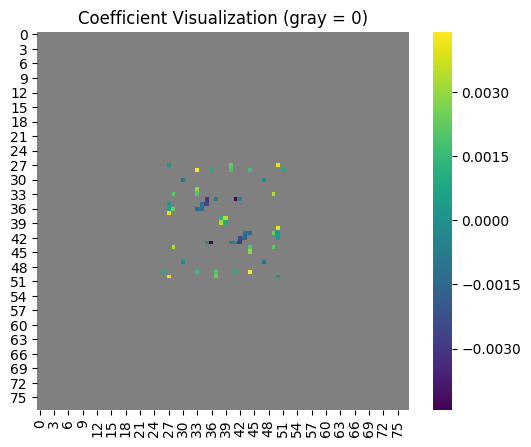

In [14]:
fig=plt.figure(figsize=(6, 5), dpi=100)
plt.title("Coefficient Visualization (gray = 0)")

sns.heatmap(coef, cmap='viridis')
# Plot for the second time as a mask
# Use gray color to represent coefficents which are 0
sns.heatmap(coef, mask=coef!=0, cmap=['gray'], cbar=False)
plt.show()

In the plot above, we can see the majority of features are reduced (gray color) by the Lasso regularization. The distribution of non-zero coefficients tells the classifier has learned to focus on features which are in the center rather than the padding. Light color squares (large positive coefficients) tend to be on the outer edge, which means larger cells are more likely to be activated.

## 3. Logistic Regression with Cell Size and Total Intensity

Instead of using the raw image pixels as features, we can use image summary statistics. We compute the cell size using the number of pixels in the cell mask generated by CellProfiler. For total intensity, we count the sum of pixel intensities in the padded cell images.

Because augmented images have the same cell size and total intensity as the original images, we only use unaugmented images to train/tune/test this model.

### 3.1. Data Preparation

To compute the cell size, one can count the pixel in the corresponding cell mask. Since it is hard to match cell index in this partial sub-sampled images, we will skip counting pixels in this notebook. The reference function is added below.

In [15]:
def compute_cell_size(image_path, mask_path, output_name, size_dict):
    """
    Crop single cells from the original image with given mask, then
    add the size to the `size_dict`.
    
    Args:
        image_path(str): path to the original image
        mask_path(str): path to the mask
        output_name(str): pre-formatted file name for output
        size_dict(dict): a dictionary mapping formated cell image name to cell size
    """

    img = cv2.imread(image_path, -1)
    img_mask = cv2.imread(mask_path, -1)

    # Count the cell number by the different values in the mask
    cell_num = np.max(img_mask)
    print(cell_num)

    for c in range(1, cell_num + 1):
        # Create the binary mask
        bin_mask = np.zeros(img_mask.shape, dtype=np.uint8)
        bin_mask[img_mask == c] = 255

        # Compute and log the pixel count
        points = cv2.findNonZero(bin_mask)
        size_dict[output_name.format(c)] = len(points)

In [16]:
# In this notebook, we skip the mask size computation process
size_dict = load(open('./resource/cell_size.json', 'r'))

# This dictionary includes cell size of filtered images and donor 4
len(size_dict)

852

In [17]:
# Organize size and total intensity into a dict
size_intensity_dict = {}

for d in [1, 2, 3, 5, 6]:
    size_intensity_dict[d] = {'feature': [], 'label':[]}
    
    # Skip filtered images
    for n in glob('./images/sample_images/processed/augmented/donor_{}/*/*.png'.format(d)):
        base_name = basename(n)
        
        # Skip augmented images
        if 'r' in base_name or 'f' in base_name:
            continue
            
        # Compute the total intensity
        cur_total_intensity = np.sum(cv2.imread(n, 0))
        cur_cell_size = size_dict[base_name]
        
        # The format of feature -> [size, total intensity]
        size_intensity_dict[d]['feature'].append([cur_cell_size, cur_total_intensity])
        size_intensity_dict[d]['label'].append(0 if 'noact' in base_name else 1)

print("Collected features (cell size and total intensity) for {} unaugmented images.".format(
    np.sum([len(size_intensity_dict[d]['feature']) for d in [1, 2, 3, 5, 6]])
))

Collected features (cell size and total intensity) for 625 unaugmented images.


In previous model, we use augmented images to train and use unaugmented images to validate. However, for this model, we only use unagumented images. We can still use the function `nested_cv(all_data, c_candidates)` to tune $\lambda$, but it requires to change the structure of `size_intensity_dict`.

In [18]:
new_size_intensity_dict = {}

for d in [1, 2, 3, 5, 6]:
    new_size_intensity_dict[d] = {
        # Use the same array for aug_x and no_aug_x as a workaround
        'aug_x': np.vstack(size_intensity_dict[d]['feature']),
        'no_aug_x': np.vstack(size_intensity_dict[d]['feature']),
        'aug_y': np.array(size_intensity_dict[d]['label']),
        'no_aug_y': np.array(size_intensity_dict[d]['label']),
    }

### 3.2. Model Tuning/Training

After gathering all the features, we can use Nested Cross-Validation to tune $\lambda$ as what we did in [section 2.2](#2.2.-Model-Tuning/Training).


In [19]:
# Smaller c gives stronger regularization power
c_candidates = [0.0001, 0.001, 0.01, 0.1, 1]
best_parameters = nested_cv(new_size_intensity_dict, c_candidates)

The average performance of parameter 0.0001 for test donor 1 is 0.9089.
The average performance of parameter 0.001 for test donor 1 is 0.8724.
The average performance of parameter 0.01 for test donor 1 is 0.8693.
The average performance of parameter 0.1 for test donor 1 is 0.8794.
The average performance of parameter 1 for test donor 1 is 0.8891.
	The best parameter for test donor 1 is 0.0001.

The average performance of parameter 0.0001 for test donor 2 is 0.7733.
The average performance of parameter 0.001 for test donor 2 is 0.7103.
The average performance of parameter 0.01 for test donor 2 is 0.7082.
The average performance of parameter 0.1 for test donor 2 is 0.7557.
The average performance of parameter 1 for test donor 2 is 0.7637.
	The best parameter for test donor 2 is 0.0001.

The average performance of parameter 0.0001 for test donor 3 is 0.7981.
The average performance of parameter 0.001 for test donor 3 is 0.7616.
The average performance of parameter 0.01 for test donor 3 is

In [20]:
best_parameters

{1: 0.0001, 2: 0.0001, 3: 0.0001, 5: 0.0001, 6: 0.0001}

For this model, $0.0001$ is the best $\lambda$ value for all 5 test donors.

### 3.3. Model Testing

Similarly to [section 2.3](#2.3.-Model-Testing), we use the best hyper-parameter value to train 5 models and measure the final performance for 5 test donors.

In [21]:
model_performance_2 = {}

for tid in [1, 2, 3, 5, 6]:
    # Collect the performance metrics for each test donor tid
    lr_model = LogisticRegression(penalty='l1', C=best_parameters[tid],
                                  random_state=RANDOM_SEED, class_weight='balanced')
    
    # Training set includes augmented images from {all donor - test donor}
    train_x = np.vstack([new_size_intensity_dict[i]['aug_x'] for i in [1, 2, 3, 5, 6] if i != tid])
    train_y = np.hstack([new_size_intensity_dict[i]['aug_y'] for i in [1, 2, 3, 5, 6] if i != tid])
    assert(train_x.shape[0] == train_y.shape[0])

    # Test set includes non-augmented images from {test donor}
    test_x = new_size_intensity_dict[tid]['no_aug_x']
    test_y = new_size_intensity_dict[tid]['no_aug_y']
    
    lr_model.fit(train_x, train_y)
    
    model_performance_2[tid] = get_score(lr_model, test_x, test_y)
    
avg_ap = np.mean([model_performance_2[d]['ap'] for d in [1, 2, 3, 5, 6]])
print("The average of Average Precision across 5 models is {:.2f}%.".format(avg_ap*100))

The average of Average Precision across 5 models is 80.05%.


In [22]:
# Create a table summary
display(Markdown(make_table(model_performance_2, count_dict)))

|Test Donor|Accuracy|Precision|Recall|Average Precision|AUC|Num of Activated|Num of Quiescent|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|donor_1|12.22%|12.22%|100.00%|39.31%|72.30%|22|158|
|donor_2|81.25%|81.25%|100.00%|95.80%|81.74%|65|15|
|donor_3|30.99%|26.62%|89.13%|79.27%|80.12%|46|125|
|donor_5|72.83%|72.83%|100.00%|92.67%|80.12%|67|25|
|donor_6|43.14%|43.14%|100.00%|93.21%|94.24%|44|58|


The performance of using two summary statistics is pretty similar to the one using raw image pixels. This model also suffers from unbalanced data.

### 3.4. Model Interpretation

Since we are only using two features, we can try to interpret the corresponding logistic regression coefficients.

In [23]:
coefs = {}

for tid in [1, 2, 3, 5, 6]:
    
    lr_model = LogisticRegression(penalty='l1', C=best_parameters[tid],
                                  random_state=RANDOM_SEED, class_weight='balanced')

    # Training set includes augmented images from {all donor - test donor}
    train_x = np.vstack([new_size_intensity_dict[i]['aug_x'] for i in [1, 2, 3, 5, 6] if i != tid])
    train_y = np.hstack([new_size_intensity_dict[i]['aug_y'] for i in [1, 2, 3, 5, 6] if i != tid])
    assert(train_x.shape[0] == train_y.shape[0])

    lr_model.fit(train_x, train_y)
    coef = lr_model.coef_[0].tolist()
    coefs[tid] = coef

coefs

{1: [-5.187560381201409e-06, 2.6656453331932554e-05],
 2: [-0.0005844068485394543, 3.493738737171258e-05],
 3: [-0.0012986006921933257, 3.979887673186713e-05],
 5: [-0.0008460341622950985, 3.841962772627861e-05],
 6: [-0.001140206625729377, 4.163192512553958e-05]}

The general trend is that the coefficient for cell size is negative while the coefficient for total intensity is positive. The absolute value of the first is larger than the latter. The following analysis is based on the coefficient for test donor 1 (trained on donor 2, 3, 5, 6).

In [24]:
# Compute the standard deviation for cell size and total intensity in donors 1, 2, 3, 5, 6
used_cell_sizes = []
used_total_intensities = []

for d in [1, 2, 3, 5, 6]:
    cur_sizes = np.vstack(new_size_intensity_dict[d]['aug_x'])[:, 0]
    cur_intensities = np.vstack(new_size_intensity_dict[d]['aug_x'])[:, 1]
    used_cell_sizes.extend(cur_sizes)
    used_total_intensities.extend(cur_intensities)

std_size = np.std(used_cell_sizes, ddof=1)
std_intensity = np.std(used_total_intensities, ddof=1)

print("The standard deviation of cell size is {:.2f}, and the std of total intensity is {:.2f}.".format(
    std_size, std_intensity))

The standard deviation of cell size is 194.20, and the std of total intensity is 25781.06.


In [25]:
or_size = np.exp(194.20 * coefs[1][0])
or_intensity = np.exp(25781.06 * coefs[1][1])

print("The odds ratio for 1 std increase of cell size is {:.4f}.".format(or_size))
print("The odds ratio for 1 std increase of total intensity is {:.4f}.".format(or_intensity))

The odds ratio for 1 std increase of cell size is 0.9990.
The odds ratio for 1 std increase of total intensity is 1.9882.


Fixing total intensity, one standard deviation increase of cell size gives an odds ratio of 0.999. The odds of being activated is 0.999 as large as the odds of being quiescent. Similarly, fixing cell size, one standard deviation increase of total intensity gives an odds ratio of 1.9882. It means that the odds of being activated is almost twice as the odds of being quiescent.

- Even though the absolute value of cell size coefficient is larger than the other coefficient, given the standard deviation of two features, this model is actually more sensitive to the change of total intensity.
- Given two cell images having the same total intensity, the larger one is slightly more "likely" to be quiescent. It makes sense because the larger cell image appears to be dimmer (total intensity is fixed).
- Given two cell images having the same cell size, the one having larger total intensity is more "likely" to be activated. It also makes sense because we have seen activated cell images tend to have high intensity pixels.

Therefore, through this interpretation analysis, we can see this logistic regression model is making "intuitive" decisions.

## 4. Logistic Regression with CellProfiler Features

Finally, we can try a logistic regression model with features extracted from a sophisticated cell imaging software. This model is very popular in the bioengineering field.

### 4.1. Data Preparation

One can CellProfiler to extract features using modules `MeasureObjectSizeShape`, `MeasureObjectIntensity`, `MeasureTexture`. We have provided our CellProfiler Pipeline at `./resource/extract_feature.cpproj`.

In this notebook, we will skip the process of running CellProfiler, but use the extracted features directly.

In [26]:
cp_df = pd.read_csv('./resource/cellprofiler_features.csv')
print(cp_df.shape)
cp_df.head()

(852, 124)


,file_name,AreaShape_Area,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,...,Texture_SumEntropy_NAH_image_3_45,Texture_SumEntropy_NAH_image_3_90,Texture_SumVariance_NAH_image_3_0,Texture_SumVariance_NAH_image_3_135,Texture_SumVariance_NAH_image_3_45,Texture_SumVariance_NAH_image_3_90,Texture_Variance_NAH_image_3_0,Texture_Variance_NAH_image_3_135,Texture_Variance_NAH_image_3_45,Texture_Variance_NAH_image_3_90
0,CD3_2_noact_1_1_47.png,427,134,226,1.396928,0.874981,0,0.550968,0.520944,35.105046,...,2.127255,2.113534,7.282513,5.743649,7.585886,8.102086,2.801257,2.335272,2.986524,2.772518
1,CD3_2_noact_1_3_46.png,208,83,187,1.006000,0.329642,1,0.764706,0.763194,16.840492,...,2.342332,2.397748,12.757461,12.841882,8.164277,11.501722,4.123398,4.161793,3.857251,3.611440
2,CD3_2_noact_1_3_49.png,203,219,213,1.373420,0.712488,1,0.464531,0.352445,21.865153,...,1.277636,1.206925,2.667760,0.324354,3.344329,2.047059,2.044887,0.154195,1.438592,0.189352
3,CD3_2_noact_1_4_5.png,291,14,20,1.091185,0.713721,1,0.661364,0.578267,23.340953,...,2.165363,2.167206,7.692172,7.119119,8.010940,9.455277,2.940050,2.890855,3.264852,3.013951
4,CD3_2_noact_1_4_21.png,250,158,132,1.003950,0.391503,1,0.816993,0.963288,18.655786,...,2.010609,2.074972,9.175630,7.312784,6.841339,7.065074,3.020903,2.762449,2.093192,2.816141


For each original cell image, we extracted 123 features.

<details><summary><em>Click here to see all 123 features</em></summary><p>

```
AreaShape_Area
AreaShape_Center_X
AreaShape_Center_Y
AreaShape_Compactness
AreaShape_Eccentricity
AreaShape_EulerNumber
AreaShape_Extent
AreaShape_FormFactor
AreaShape_MajorAxisLength
AreaShape_MaxFeretDiameter
AreaShape_MaximumRadius
AreaShape_MeanRadius
AreaShape_MedianRadius
AreaShape_MinFeretDiameter
AreaShape_MinorAxisLength
AreaShape_Orientation
AreaShape_Perimeter
AreaShape_Solidity
AreaShape_Zernike_0_0
AreaShape_Zernike_1_1
AreaShape_Zernike_2_0
AreaShape_Zernike_2_2
AreaShape_Zernike_3_1
AreaShape_Zernike_3_3
AreaShape_Zernike_4_0
AreaShape_Zernike_4_2
AreaShape_Zernike_4_4
AreaShape_Zernike_5_1
AreaShape_Zernike_5_3
AreaShape_Zernike_5_5
AreaShape_Zernike_6_0
AreaShape_Zernike_6_2
AreaShape_Zernike_6_4
AreaShape_Zernike_6_6
AreaShape_Zernike_7_1
AreaShape_Zernike_7_3
AreaShape_Zernike_7_5
AreaShape_Zernike_7_7
AreaShape_Zernike_8_0
AreaShape_Zernike_8_2
AreaShape_Zernike_8_4
AreaShape_Zernike_8_6
AreaShape_Zernike_8_8
AreaShape_Zernike_9_1
AreaShape_Zernike_9_3
AreaShape_Zernike_9_5
AreaShape_Zernike_9_7
AreaShape_Zernike_9_9
Intensity_IntegratedIntensityEdge_NAH_image
Intensity_IntegratedIntensity_NAH_image
Intensity_LowerQuartileIntensity_NAH_image
Intensity_MADIntensity_NAH_image
Intensity_MassDisplacement_NAH_image
Intensity_MaxIntensityEdge_NAH_image
Intensity_MaxIntensity_NAH_image
Intensity_MeanIntensityEdge_NAH_image
Intensity_MeanIntensity_NAH_image
Intensity_MedianIntensity_NAH_image
Intensity_MinIntensityEdge_NAH_image
Intensity_MinIntensity_NAH_image
Intensity_StdIntensityEdge_NAH_image
Intensity_StdIntensity_NAH_image
Intensity_UpperQuartileIntensity_NAH_image
Location_CenterMassIntensity_X_NAH_image
Location_CenterMassIntensity_Y_NAH_image
Location_Center_X
Location_Center_Y
Location_MaxIntensity_X_NAH_image
Location_MaxIntensity_Y_NAH_image
Number_Object_Number
Texture_AngularSecondMoment_NAH_image_3_0
Texture_AngularSecondMoment_NAH_image_3_135
Texture_AngularSecondMoment_NAH_image_3_45
Texture_AngularSecondMoment_NAH_image_3_90
Texture_Contrast_NAH_image_3_0
Texture_Contrast_NAH_image_3_135
Texture_Contrast_NAH_image_3_45
Texture_Contrast_NAH_image_3_90
Texture_Correlation_NAH_image_3_0
Texture_Correlation_NAH_image_3_135
Texture_Correlation_NAH_image_3_45
Texture_Correlation_NAH_image_3_90
Texture_DifferenceEntropy_NAH_image_3_0
Texture_DifferenceEntropy_NAH_image_3_135
Texture_DifferenceEntropy_NAH_image_3_45
Texture_DifferenceEntropy_NAH_image_3_90
Texture_DifferenceVariance_NAH_image_3_0
Texture_DifferenceVariance_NAH_image_3_135
Texture_DifferenceVariance_NAH_image_3_45
Texture_DifferenceVariance_NAH_image_3_90
Texture_Entropy_NAH_image_3_0
Texture_Entropy_NAH_image_3_135
Texture_Entropy_NAH_image_3_45
Texture_Entropy_NAH_image_3_90
Texture_Gabor_NAH_image_3
Texture_InfoMeas1_NAH_image_3_0
Texture_InfoMeas1_NAH_image_3_135
Texture_InfoMeas1_NAH_image_3_45
Texture_InfoMeas1_NAH_image_3_90
Texture_InfoMeas2_NAH_image_3_0
Texture_InfoMeas2_NAH_image_3_135
Texture_InfoMeas2_NAH_image_3_45
Texture_InfoMeas2_NAH_image_3_90
Texture_InverseDifferenceMoment_NAH_image_3_0
Texture_InverseDifferenceMoment_NAH_image_3_135
Texture_InverseDifferenceMoment_NAH_image_3_45
Texture_InverseDifferenceMoment_NAH_image_3_90
Texture_SumAverage_NAH_image_3_0
Texture_SumAverage_NAH_image_3_135
Texture_SumAverage_NAH_image_3_45
Texture_SumAverage_NAH_image_3_90
Texture_SumEntropy_NAH_image_3_0
Texture_SumEntropy_NAH_image_3_135
Texture_SumEntropy_NAH_image_3_45
Texture_SumEntropy_NAH_image_3_90
Texture_SumVariance_NAH_image_3_0
Texture_SumVariance_NAH_image_3_135
Texture_SumVariance_NAH_image_3_45
Texture_SumVariance_NAH_image_3_90
Texture_Variance_NAH_image_3_0
Texture_Variance_NAH_image_3_135
Texture_Variance_NAH_image_3_45
Texture_Variance_NAH_image_3_90
```
</p></details>

In [27]:
# Then, we want to organize the features following the feature data structure in
# previous models
cp_data_dict = {}
for d in [1, 2, 3, 5, 6]:
    cp_data_dict[d] = {'aug_x': [], 'aug_y':[], 'no_aug_x': [], 'no_aug_y': []}
    
# Filter images from the df
selected_images = set([basename(i) for i in glob('./images/sample_images/processed/augmented/*/*/*.png')
                      if 'r' not in basename(i) and 'f' not in basename(i)])

# Iterate through the cp feature dataframe row by row
for i, r in cp_df.iterrows():
    
    # Parse image information from the file_name
    cur_name = r[0]
    cur_donor = int(re.sub(r'.*_(\d)_.*_.*_.*_.*\.png', r'\1', cur_name))
    cur_label = 0 if 'noact' in cur_name else 1
    
    # Skip donor 4 and filtered images
    if cur_name not in selected_images or cur_donor == 4:
        continue

    # The first entry is file name, all others are features
    cur_feature = r[1:].tolist()

    # Add features into the feature dictionary
    # We add the same feature to both augmented and augmented entries to follow nested_cv API
    cp_data_dict[cur_donor]['aug_x'].append(cur_feature)
    cp_data_dict[cur_donor]['no_aug_x'].append(cur_feature)
    cp_data_dict[cur_donor]['aug_y'].append(cur_label)
    cp_data_dict[cur_donor]['no_aug_y'].append(cur_label)

### 4.2. Model Tuning/Training

Same as before, we start to tune the $\lambda$ value after preparing all training data. In this model, we do not use augmented images, because they have the same CellProfiler features.

In [28]:
# Smaller c gives stronger regularization power
c_candidates = [0.0001, 0.001, 0.01, 0.1, 1]
best_parameters = nested_cv(cp_data_dict, c_candidates)

The average performance of parameter 0.0001 for test donor 1 is 0.7103.
The average performance of parameter 0.001 for test donor 1 is 0.8126.
The average performance of parameter 0.01 for test donor 1 is 0.8305.
The average performance of parameter 0.1 for test donor 1 is 0.8986.
The average performance of parameter 1 for test donor 1 is 0.9288.
	The best parameter for test donor 1 is 1.

The average performance of parameter 0.0001 for test donor 2 is 0.7490.
The average performance of parameter 0.001 for test donor 2 is 0.8334.
The average performance of parameter 0.01 for test donor 2 is 0.8845.
The average performance of parameter 0.1 for test donor 2 is 0.8615.
The average performance of parameter 1 for test donor 2 is 0.8501.
	The best parameter for test donor 2 is 0.01.

The average performance of parameter 0.0001 for test donor 3 is 0.5654.
The average performance of parameter 0.001 for test donor 3 is 0.7339.
The average performance of parameter 0.01 for test donor 3 is 0.7424

For this time, we get different optimal $\lambda$ for different test donors.

### 4.3. Model Testing

Then, we use the best $\lambda$ value to train and test a new model for each test donor.

In [29]:
model_performance_3 = {}

for tid in [1, 2, 3, 5, 6]:
    # Collect the performance metrics for each test donor tid
    lr_model = LogisticRegression(penalty='l1', C=best_parameters[tid],
                                  random_state=RANDOM_SEED, class_weight='balanced')
    
    # Training set includes augmented images from {all donor - test donor}
    train_x = np.vstack([cp_data_dict[i]['aug_x'] for i in [1, 2, 3, 5, 6] if i != tid])
    train_y = np.hstack([cp_data_dict[i]['aug_y'] for i in [1, 2, 3, 5, 6] if i != tid])
    assert(train_x.shape[0] == train_y.shape[0])

    # Test set includes non-augmented images from {test donor}
    test_x = cp_data_dict[tid]['no_aug_x']
    test_y = cp_data_dict[tid]['no_aug_y']
    
    lr_model.fit(train_x, train_y)
    
    model_performance_3[tid] = get_score(lr_model, test_x, test_y)
    
avg_ap = np.mean([model_performance_3[d]['ap'] for d in [1, 2, 3, 5, 6]])
print("The average of Average Precision across 5 models is {:.2f}%.".format(avg_ap*100))

The average of Average Precision across 5 models is 81.13%.


In [30]:
# Create a table summary
display(Markdown(make_table(model_performance_3, count_dict)))

|Test Donor|Accuracy|Precision|Recall|Average Precision|AUC|Num of Activated|Num of Quiescent|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|donor_1|90.56%|60.00%|68.18%|66.26%|85.41%|22|158|
|donor_2|50.00%|72.73%|61.54%|70.66%|24.10%|65|15|
|donor_3|91.23%|94.29%|71.74%|94.58%|97.58%|46|125|
|donor_5|71.74%|73.56%|95.52%|76.56%|57.19%|67|25|
|donor_6|87.25%|78.18%|97.73%|97.60%|98.04%|44|58|


Even though the Average Precision mean across 5 test donors is similar to the previous two models, all average precision is above $50\%$ now. One can argue that logistic regression model using CellProfiler features is less sensitive to skewed data.

### 4.4. Model Interpretation

Finally, we can check which features are reduced by Lasso regularization and gain more insights about this model. The following analysis is based on the model trained for test donor 1.

In [31]:
tid = 1
lr_model = LogisticRegression(penalty='l1', C=best_parameters[tid],
                              random_state=RANDOM_SEED, class_weight='balanced')

# Training set includes augmented images from {all donor - test donor}
train_x = np.vstack([cp_data_dict[i]['aug_x'] for i in [1, 2, 3, 5, 6] if i != tid])
train_y = np.hstack([cp_data_dict[i]['aug_y'] for i in [1, 2, 3, 5, 6] if i != tid])
assert(train_x.shape[0] == train_y.shape[0])

lr_model.fit(train_x, train_y)
coef = lr_model.coef_[0]

print("{} out of {} features are reduced by L1 penalty.".format(
    sum(coef == 0), len(coef)
))

88 out of 123 features are reduced by L1 penalty.


We can visualize the coefficient of these left 35 selected features.

In [32]:
# Find the feature name
feature_names = list(cp_df)[1:]
selected_feature_index = [True if i != 0 else False for i in coef]
selected_coefs = coef[selected_feature_index]
selected_feature_names = np.array(feature_names)[selected_feature_index]
selected_cp_df = pd.DataFrame({
    'selected_names': selected_feature_names.tolist(),
    'selected_coefs': selected_coefs 
})
selected_feature_names

array(['AreaShape_Area', 'AreaShape_Center_X', 'AreaShape_Center_Y',
       'AreaShape_Compactness', 'AreaShape_Eccentricity',
       'AreaShape_EulerNumber', 'AreaShape_MajorAxisLength',
       'AreaShape_MaxFeretDiameter', 'AreaShape_MedianRadius',
       'AreaShape_MinFeretDiameter', 'AreaShape_MinorAxisLength',
       'AreaShape_Orientation', 'AreaShape_Perimeter',
       'Intensity_IntegratedIntensityEdge_NAH_image',
       'Intensity_IntegratedIntensity_NAH_image',
       'Intensity_MassDisplacement_NAH_image',
       'Intensity_MaxIntensity_NAH_image',
       'Location_CenterMassIntensity_X_NAH_image', 'Location_Center_Y',
       'Location_MaxIntensity_X_NAH_image',
       'Location_MaxIntensity_Y_NAH_image', 'Number_Object_Number',
       'Texture_Contrast_NAH_image_3_90',
       'Texture_Correlation_NAH_image_3_45',
       'Texture_DifferenceVariance_NAH_image_3_135',
       'Texture_Gabor_NAH_image_3', 'Texture_InfoMeas2_NAH_image_3_0',
       'Texture_SumAverage_NAH_image_3_

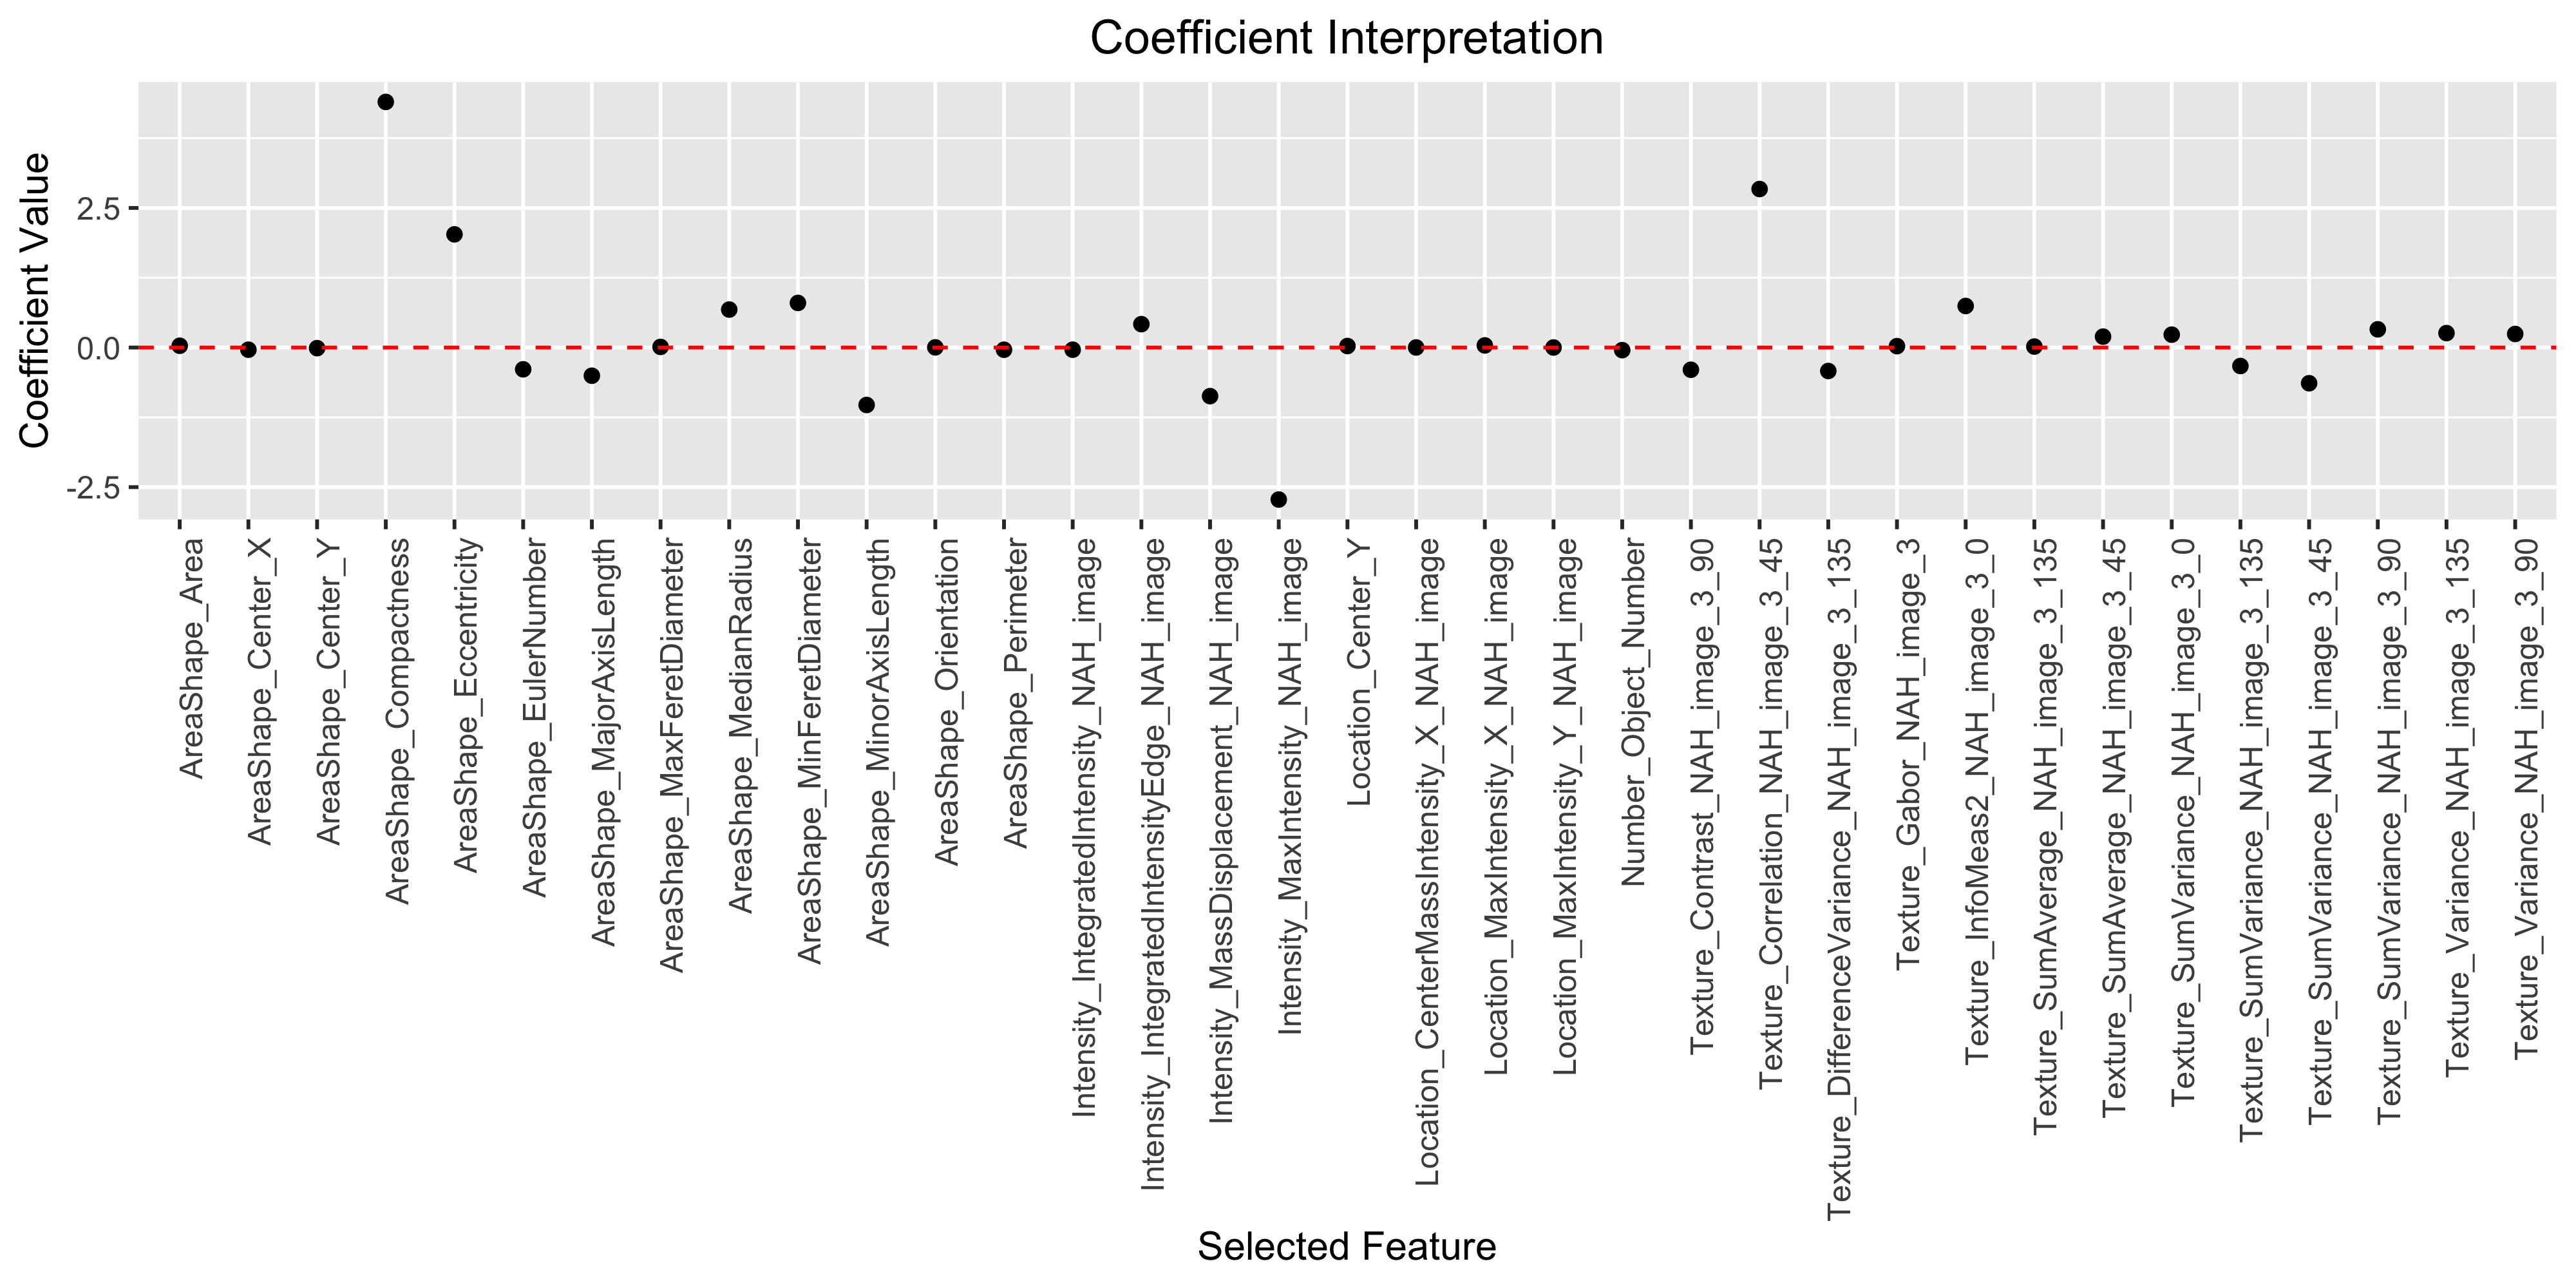

In [39]:
%%R -i selected_cp_df -w 10 -h 5 --units in -r 400

library(ggplot2)
selected_cp_df$feature = factor(selected_cp_df$selected_names)

# Plot the coefficient value vs. feature name
ggplot(selected_cp_df, aes(x=feature, y=selected_coefs)) + 
    geom_point() + 
    xlab("Selected Feature") +
    ylab("Coefficient Value") +
    ggtitle("Coefficient Interpretation") +
    geom_hline(yintercept=0, linetype="dashed", color = "red") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          plot.title = element_text(hjust = 0.5))

Within these 35 Lasso-selected features, `Compactiness`, `Eccentinicity`, `MaxIntensity` and `Texture Correlation` are the most significant features. One can aggregate standard deviation for these features and further interpret these four coefficients as in [section 3.4](#3.4.-Model-Interpretation).

## 5. Summary

In this notebook we have explored three logistic regression models with different features using the Nested Cross-Validation scheme. The average test performance of three models are quite similar, but each model performs differently for specific test donors. In addition, we have seen the interpretability of linear models really helps us understand these classifiers.

Finally, we can plot and compare the performance of three models with three metrics (accuracy, average precision and AUC).

In [34]:
summary_dict = {
    'method': [],
    'donor': [],
    'auc': [],
    'ap': [],
    'acc': []
}

performance_collection_dict = {
    'LR (Intensities)': model_performance_1,
    'LR (Total Intensity + Size)': model_performance_2,
    'LR (CellProfiler Features)': model_performance_3 
}

for m in performance_collection_dict:
    for d in [1, 2, 3, 5, 6]:
        cur_model = performance_collection_dict[m]
        summary_dict['method'].append(m)
        summary_dict['donor'].append(d)
        summary_dict['auc'].append(cur_model[d]['aroc'])
        summary_dict['ap'].append(cur_model[d]['ap'])
        summary_dict['acc'].append(cur_model[d]['acc'])

metric_df = pd.DataFrame(summary_dict)
metric_df

,method,donor,auc,ap,acc
0,LR (Intensities),1,0.730437,0.459899,0.650000
1,LR (Intensities),2,0.711795,0.924539,0.600000
2,LR (Intensities),3,0.867304,0.783544,0.713450
3,LR (Intensities),5,0.744478,0.905516,0.673913
4,LR (Intensities),6,0.894984,0.892835,0.813725
5,LR (Total Intensity + Size),1,0.722957,0.393094,0.122222
6,LR (Total Intensity + Size),2,0.817436,0.958037,0.812500
7,LR (Total Intensity + Size),3,0.801217,0.792662,0.309942
8,LR (Total Intensity + Size),5,0.801194,0.926732,0.728261
9,LR (Total Intensity + Size),6,0.942398,0.932146,0.431373


In [35]:
# Convert count df to a R data.frame
count_dict
count_r_dict = {'count': [], 'donor': [], 'variable': []}
for v in ['Activated', 'Quiescent']:
    for d in [1, 2, 3, 5, 6]:
        count_r_dict['count'].append(count_dict[d]['activated' if v == 'Activated' else 'quiescent'])
        count_r_dict['donor'].append(d)
        count_r_dict['variable'].append(v)
count_df = pd.DataFrame(count_r_dict)
count_df

,count,donor,variable
0,22,1,Activated
1,65,2,Activated
2,46,3,Activated
3,67,5,Activated
4,44,6,Activated
5,158,1,Quiescent
6,15,2,Quiescent
7,125,3,Quiescent
8,25,5,Quiescent
9,58,6,Quiescent


In [36]:
%reload_ext rpy2.ipython

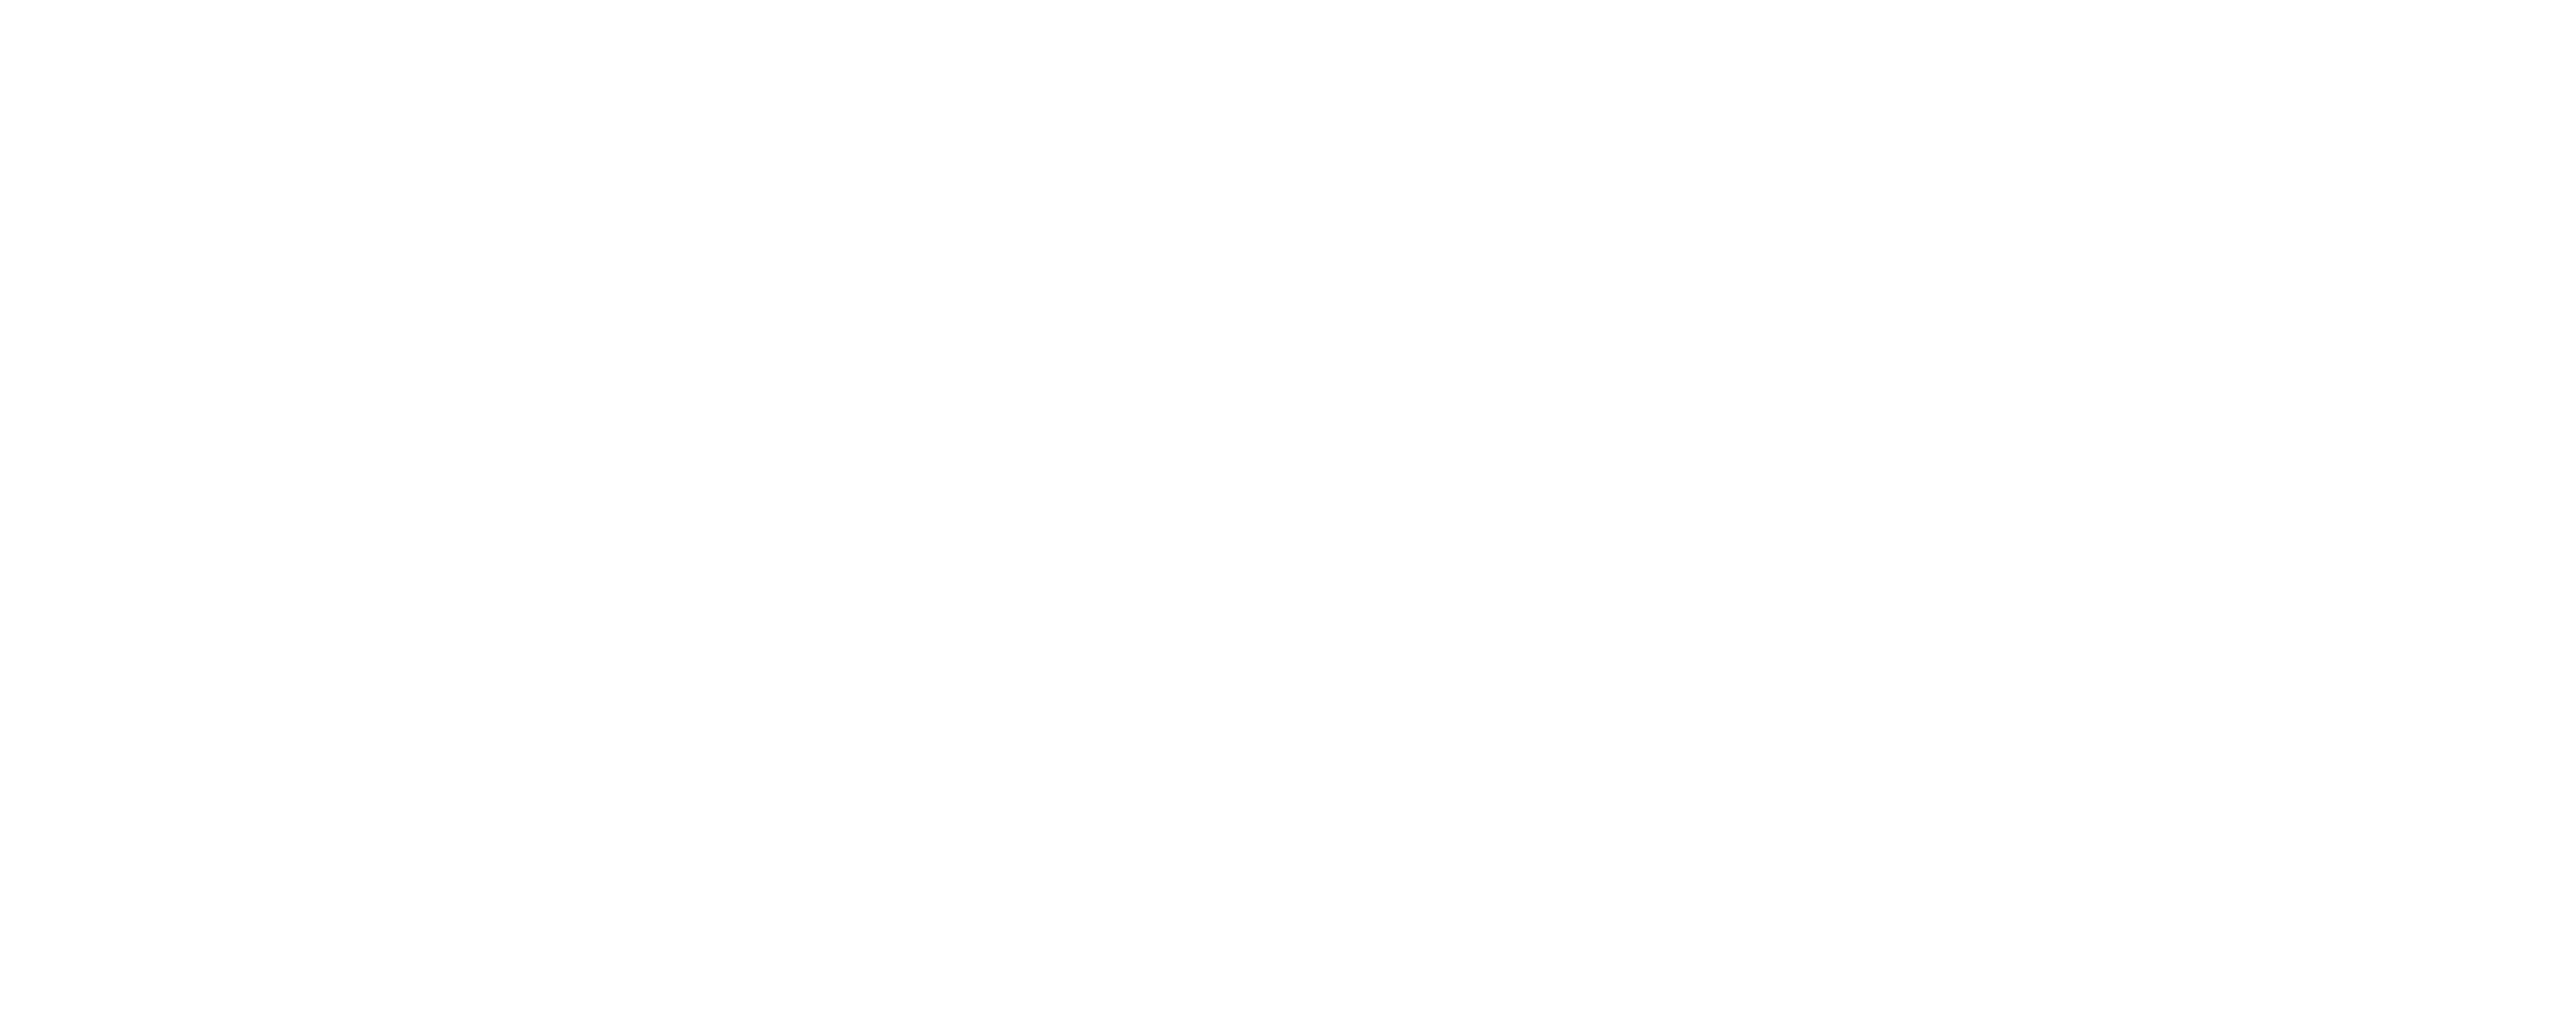

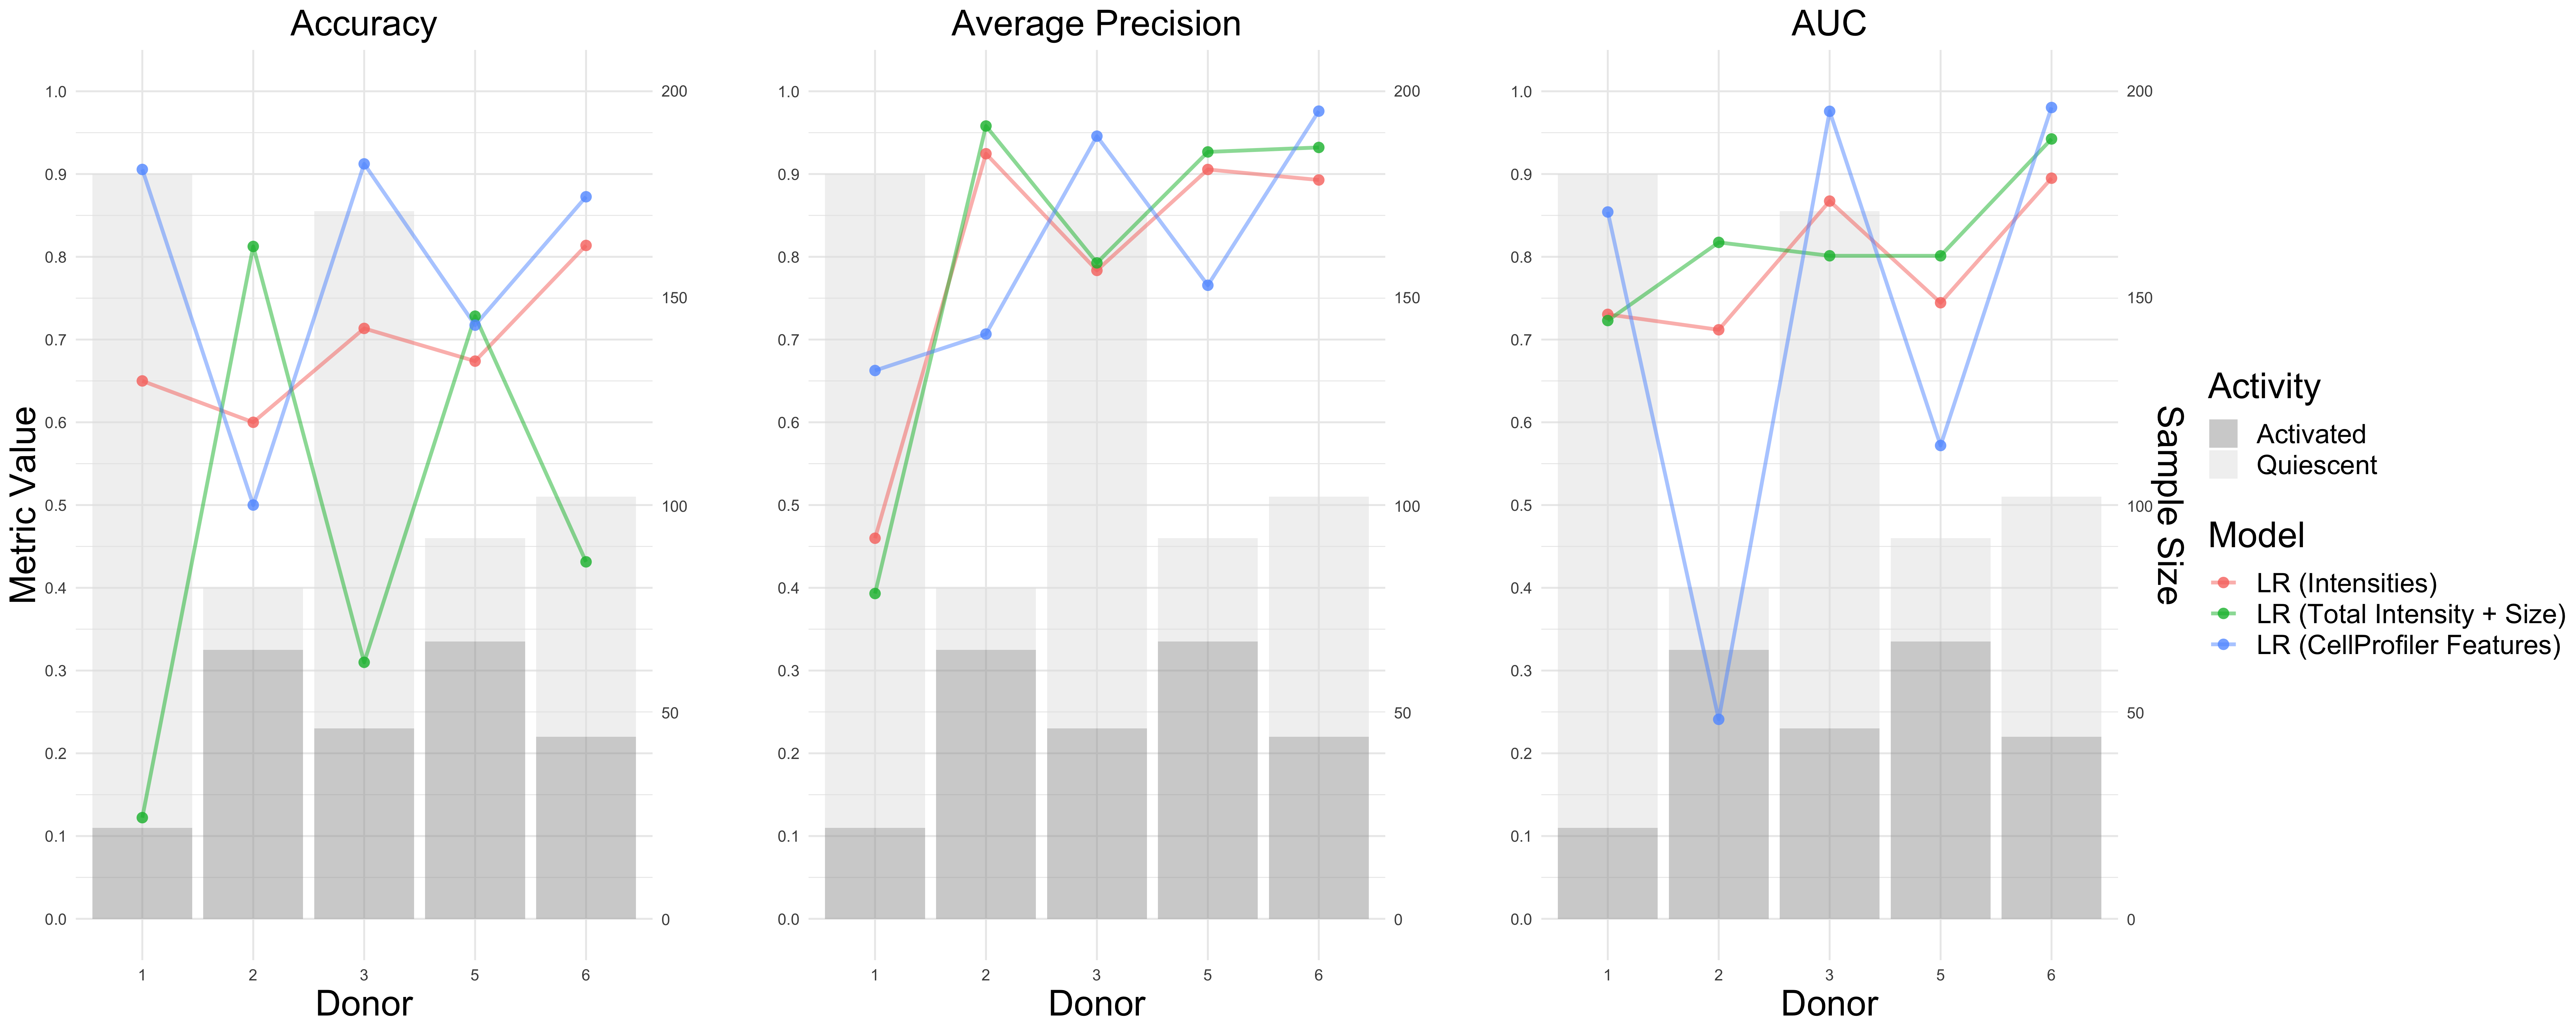

In [38]:
%%R -i metric_df,count_df -w 20 -h 8 --units in -r 400

library("ggplot2")
library("ggpubr")
library("magrittr")

level_order = c("LR (Intensities)",
                "LR (Total Intensity + Size)",
                "LR (CellProfiler Features)")

# Convert discrete columns into R factors
metric_df$donor = factor(metric_df$donor)
metric_df$method = factor(metric_df$method, levels=level_order)
count_df$variable = factor(count_df$variable)
count_df$donor = factor(count_df$donor)

line_size = 1
point_size = 3

# Accuracy plot
p1 = ggplot() +
    scale_y_continuous(sec.axis = sec_axis(~ 200*., name=""),
                       breaks = scales::pretty_breaks(n = 10),
                       limits = c(0, 1)) +
    geom_col(data=count_df, aes(x=donor, y=count/200, fill=variable),
             position = position_stack(reverse = TRUE)) +
    geom_line(data=metric_df, aes(x=donor, y=acc, color=method, group=method),
              size=line_size, alpha=0.5) +
    geom_point(data=metric_df, aes(x=donor, y=acc, color=method),
               size=point_size, alpha=0.8, stroke=0) +
    scale_fill_manual(values=c(alpha("#A2A2A2", 0.5), alpha("#E3E3E3", 0.5))) +
    ggtitle("Accuracy") +
    labs(color="Model", fill="Activity", x="Donor",
         y="Metric Value") +
    theme_minimal()+
    theme(plot.title = element_text(hjust = 0.5, size=20),
          axis.title = element_text(size = 20),
          legend.title = element_text(size = 20), 
          legend.text = element_text(size = 15)) 

# AP plot
p2 = ggplot() +
    scale_y_continuous(sec.axis = sec_axis(~ 200*., name=""),
                       breaks = scales::pretty_breaks(n = 10),
                       limits = c(0, 1)) +
    geom_col(data=count_df, aes(x=donor, y=count/200, fill=variable),
             position = position_stack(reverse = TRUE)) +
    geom_line(data=metric_df, aes(x=donor, y=ap, color=method, group=method),
              size=line_size, alpha=0.5) +
    geom_point(data=metric_df, aes(x=donor, y=ap, color=method),
               size=point_size, alpha=0.8, stroke=0) +
    scale_fill_manual(values=c(alpha("#A2A2A2", 0.5), alpha("#E3E3E3", 0.5))) +
    ggtitle("Average Precision") +
    labs(color="Model", fill="Activity", x="Donor",
         y="") +
    theme_minimal()+
    theme(plot.title = element_text(hjust = 0.5, size=20),
          axis.title = element_text(size = 20),
          legend.title = element_text(size = 20), 
          legend.text = element_text(size = 15)) 

# AUC plot
p3 = ggplot() +
    scale_y_continuous(sec.axis = sec_axis(~ 200*., name="Sample Size"),
                       breaks = scales::pretty_breaks(n = 10),
                       limits = c(0, 1)) +
    geom_col(data=count_df, aes(x=donor, y=count/200, fill=variable),
             position = position_stack(reverse = TRUE)) +
    geom_line(data=metric_df, aes(x=donor, y=auc, color=method, group=method),
              size=line_size, alpha=0.5) +
    geom_point(data=metric_df, aes(x=donor, y=auc, color=method),
               size=point_size, alpha=0.8, stroke=0) +
    scale_fill_manual(values=c(alpha("#A2A2A2", 0.5), alpha("#E3E3E3", 0.5))) +
    ggtitle("AUC") +
    labs(color="Model", fill="Activity", x="Donor",
         y="") +
    theme_minimal()+
    theme(plot.title = element_text(hjust = 0.5, size=20),
          axis.title = element_text(size = 20),
          legend.title = element_text(size = 20), 
          legend.text = element_text(size = 20)) 

ggarrange(p1, p2, p3, ncol=3, common.legend = TRUE, legend="right", align='h')

Since we are only using a small portion of all data here, this model comparison is not really meaningful. However, the visualization design can be adopted into other projects.